# Introduction to Recommender Systems

Recommender systems are one of the most successful and widespread application of machine learning technologies in business. You can apply recommender systems in scenarios where many users interact with many items. For e.g. Amazon recommends items that you can buy, Youtube Recommendations, Spotify and so on.

## Why its important
Recommender systems can help match users to items. They help item provider deliver their items to right user. Identify products most relevant to the user.
Content Personalisation and also Help website improve user engagement and increase online sales

## Key approaches
1. Collaborative Filtering
2. Content Based Filtering
3. Popularity Based Filtering

## Examples
- Recommended Items viewed / purchased by most people (Popularity Based)
    - Not Personalised, purely based on volume or counts
- Recommended item based on the item you purchased recently, recommended music based on your selected interest areas (Content Based)
    - <a href="https://miro.medium.com/max/1334/1*oYpMnPQFZaiZQizgVWBpoA.png"><img src="https://miro.medium.com/max/1334/1*oYpMnPQFZaiZQizgVWBpoA.png" alt="Content Based" border="0" width="200" height="200"></a>
- Recommended items based on other users with similar interests (Collaborative)
    - Item based Collaborative Filtering <a href="https://ibb.co/droZMy"><img src="https://preview.ibb.co/feq3EJ/resim_a.jpg" alt="Item Based" border="0" width="200" height="200"></a>
    - User based Collaborative Filtering <a href="https://imgbb.com/"><img src="https://image.ibb.co/maEQdd/resim_b.jpg" alt="User Based" border="0" width="200" height="200"></a>

## Python Code

The most common recommendation systems are:
- Content Based Filtering
- Collborative Filtering

Lot of research has demonstrated that a hybrid approach, combining collaborative filtering and content-based filtering could be more effective than pure approaches in some cases. These methods can also be used to overcome some of the common problems in recommender systems such as cold start and the sparsity problem.

In this notebook, I use a dataset that's shared on Kaggle: [Articles Sharing and Reading from CI&T Deskdrop](https://www.kaggle.com/gspmoreira/articles-sharing-reading-from-cit-deskdrop).  

The notebook will demonstrate how to implement **Collaborative Filtering**, **Content-Based Filtering** and **Hybrid methods**, to provide personalized recommendations to the users.

In [2]:
# Import all required libraries
import numpy as np
import scipy
import pandas as pd
import math
import random
import sklearn
from nltk.corpus import stopwords
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse.linalg import svds
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

## Load the Kaggle Dataset

The dataset contains a real sample of 12 months logs. It contains about thousands of logged users interactions on more than 3000 public articles shared in the platform. It is composed of two CSV files:  
### shared_articles.csv
Contains information about the articles shared in the platform. Each article has its sharing date (timestamp), the original url, title, content in plain text, the article language and information about the user who shared the article.
There are two possible event types at a given timestamp: 
- CONTENT SHARED: The article was shared in the platform and is available for users. 
- CONTENT REMOVED: The article was removed from the platform and not available for further recommendation.

*Note:For this exercise, I only consider the "CONTENT SHARED" event type, assuming that all articles were available during the whole period.* 

## users_interactions.csv
Contains logs of user interactions on shared articles. It can be joined to previous data by **contentId** column.
The eventType values are:  
- VIEW: The user has opened the article. 
- LIKE: The user has liked the article. 
- COMMENT CREATED: The user created a comment in the article. 
- FOLLOW: The user chose to be notified on any new comment in the article. 
- BOOKMARK: The user has bookmarked the article for easy return in the future.

In [3]:
articles = pd.read_csv('shared_articles.csv')
articles = articles[articles['eventType'] == 'CONTENT SHARED']
articles.head(5)

,timestamp,eventType,contentId,authorPersonId,authorSessionId,authorUserAgent,authorRegion,authorCountry,contentType,url,title,text,lang
1,1459193988,CONTENT SHARED,-4110354420726924665,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://www.nytimes.com/2016/03/28/business/dea...,"Ethereum, a Virtual Currency, Enables Transact...",All of this work is still very early. The firs...,en
2,1459194146,CONTENT SHARED,-7292285110016212249,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://cointelegraph.com/news/bitcoin-future-w...,Bitcoin Future: When GBPcoin of Branson Wins O...,The alarm clock wakes me at 8:00 with stream o...,en
3,1459194474,CONTENT SHARED,-6151852268067518688,3891637997717104548,-1457532940883382585,NaN,NaN,NaN,HTML,https://cloudplatform.googleblog.com/2016/03/G...,Google Data Center 360° Tour,We're excited to share the Google Data Center ...,en
4,1459194497,CONTENT SHARED,2448026894306402386,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,https://bitcoinmagazine.com/articles/ibm-wants...,"IBM Wants to ""Evolve the Internet"" With Blockc...",The Aite Group projects the blockchain market ...,en
5,1459194522,CONTENT SHARED,-2826566343807132236,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://www.coindesk.com/ieee-blockchain-oxford...,IEEE to Talk Blockchain at Cloud Computing Oxf...,One of the largest and oldest organizations fo...,en


In [4]:
interactions = pd.read_csv('users_interactions.csv')
interactions.head(10)

,timestamp,eventType,contentId,personId,sessionId,userAgent,userRegion,userCountry
0,1465413032,VIEW,-3499919498720038879,-8845298781299428018,1264196770339959068,NaN,NaN,NaN
1,1465412560,VIEW,8890720798209849691,-1032019229384696495,3621737643587579081,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_2...,NY,US
2,1465416190,VIEW,310515487419366995,-1130272294246983140,2631864456530402479,NaN,NaN,NaN
3,1465413895,FOLLOW,310515487419366995,344280948527967603,-3167637573980064150,NaN,NaN,NaN
4,1465412290,VIEW,-7820640624231356730,-445337111692715325,5611481178424124714,NaN,NaN,NaN
5,1465413742,VIEW,310515487419366995,-8763398617720485024,1395789369402380392,Mozilla/5.0 (Windows NT 10.0; WOW64) AppleWebK...,MG,BR
6,1465415950,VIEW,-8864073373672512525,3609194402293569455,1143207167886864524,NaN,NaN,NaN
7,1465415066,VIEW,-1492913151930215984,4254153380739593270,8743229464706506141,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...,SP,BR
8,1465413762,VIEW,310515487419366995,344280948527967603,-3167637573980064150,NaN,NaN,NaN
9,1465413771,VIEW,3064370296170038610,3609194402293569455,1143207167886864524,NaN,NaN,NaN


## Data Transformatiom

As there are different interactions types, let's associate them with a weight or strength, assuming that, for example, a comment in an article indicates a higher interest of the user on the item than a like, or than a simple view.

In [5]:
# Convert Event Type to Numerical Weights
eventStrength = {
   'VIEW': 1.0,
   'LIKE': 2.0, 
   'BOOKMARK': 2.5, 
   'FOLLOW': 3.0,
   'COMMENT CREATED': 4.0,  
}

interactions['eventStrength'] = interactions['eventType'].apply(lambda x: eventStrength[x])
interactions.head()

,timestamp,eventType,contentId,personId,sessionId,userAgent,userRegion,userCountry,eventStrength
0,1465413032,VIEW,-3499919498720038879,-8845298781299428018,1264196770339959068,NaN,NaN,NaN,1.0
1,1465412560,VIEW,8890720798209849691,-1032019229384696495,3621737643587579081,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_2...,NY,US,1.0
2,1465416190,VIEW,310515487419366995,-1130272294246983140,2631864456530402479,NaN,NaN,NaN,1.0
3,1465413895,FOLLOW,310515487419366995,344280948527967603,-3167637573980064150,NaN,NaN,NaN,3.0
4,1465412290,VIEW,-7820640624231356730,-445337111692715325,5611481178424124714,NaN,NaN,NaN,1.0


One of the problem in Recommender systems is **user cold-start**, in which is hard do provide personalized recommendations for users with none or a very few number of consumed items, due to the lack of information to model their preferences. For this reason, let's keep only users with at least 5 interactions.

In [6]:
usersInteractionsCount = interactions.groupby(['personId', 'contentId']).size().groupby('personId').size()
print('Total users: %d' % len(usersInteractionsCount))
usersWithEnoughInteractions = usersInteractionsCount[usersInteractionsCount >= 5].reset_index()[['personId']]
print('Users with at least 5 interactions: %d' % len(usersWithEnoughInteractions))

Total users: 1895
Users with at least 5 interactions: 1140


In [7]:
print('Total Number of interactions: %d' % len(interactions))
interactionsFromSelectedUsers = interactions.merge(usersWithEnoughInteractions, 
               how = 'right',
               left_on = 'personId',
               right_on = 'personId')
print('Number of interactions from users with at least 5 interactions: %d' % len(interactionsFromSelectedUsers))

Total Number of interactions: 72312
Number of interactions from users with at least 5 interactions: 69868


As per this dataset, users are allowed to view an article many times, and interact with them in different ways (eg. like or comment). Thus, to model the user interest on a given article, let's aggregate all the interactions the user has performed in an item by a weighted sum of interaction type strength and apply a log transformation to smooth the distribution.

In [8]:
def smoothUserPreference(x):
    return math.log(1+x, 2)
    
uniqueInteractions = interactionsFromSelectedUsers \
                    .groupby(['personId', 'contentId'])['eventStrength'].sum() \
                    .apply(smoothUserPreference).reset_index()
print('Number of unique user/item interactions: %d' % len(uniqueInteractions))
uniqueInteractions.sample(10)

Number of unique user/item interactions: 39106


,personId,contentId,eventStrength
11118,-3362047598052899495,-5414889822782394955,2.000000
9932,-3643155458357242906,-2489051066377567114,1.000000
38846,9105269044962898535,8297658253225035519,1.000000
19566,-57558373945119606,1441248639512899483,1.000000
7458,-5292464982436362617,-1480913447590268358,1.584963
6369,-6030696784871381528,5533752987392101383,1.000000
35612,7392990465409599343,2231749805468232267,1.000000
28925,3681539658619684640,-7169261479876586557,1.000000
25801,2901546026085255870,-5912792039759735631,1.000000
32190,5127372011815639401,5217724704513784613,1.000000


## Model Evaluation & Tuning

Model evaluation is important in all machine learning projects, it allows to compare objectivelly different algorithms and hyperparameter choices for models.  
One key aspect of evaluation is to ensure that the trained model generalizes for data it was not trained on, using **Cross-validation** techniques. I am using here a simple cross-validation approach named **holdout**, in which a random data sample are kept aside in the training process, and exclusively used for evaluation. All evaluation metrics reported here are computed using the **test set**.

In [9]:
trainInteractions, testInteractions = train_test_split(uniqueInteractions,
                                   stratify=uniqueInteractions['personId'], 
                                   test_size=0.30,
                                   random_state=100)

print('Total interactions on Train set: %d' % len(trainInteractions))
print('Total interactions on Test set: %d' % len(testInteractions))

Total interactions on Train set: 27374
Total interactions on Test set: 11732


In [10]:
trainInteractions.sample(2)

,personId,contentId,eventStrength
24884,2416280733544962613,4991224059205503283,1.584963
15358,-1479311724257856983,1549650080907932816,2.584963


In Recommender Systems, there are a set metrics commonly used for evaluation. I chose to work with **Top-N accuracy metrics**, which evaluates the accuracy of the top recommendations provided to a user, comparing to the items the user has actually interacted in test set.  
This evaluation method works as follows:

* For each user
    * For each item the user has interacted in test set
        * Sample 100 other items the user has never interacted.   
            * *Note: Here I assume those non interacted items are not relevant to the user, which might not be true, as the user may simply not be aware of those not interacted items. But let's keep this assumption for simplicity*
        * Ask the recommender model to produce a ranked list of recommended items, from a set composed one interacted item and the 100 non-interacted items
        * Compute the Top-N accuracy metrics for this user and interacted item from the recommendations ranked list
* Aggregate the global Top-N accuracy metrics

In [11]:
#Indexing by personId to speed up the searches during evaluation
indexedUniqueinteractions = uniqueInteractions.set_index('personId')
indexedTrainInteractions = trainInteractions.set_index('personId')
indexedTestInteractions = testInteractions.set_index('personId')

In [12]:
def getItemsInteracted(personId, interactions):
    # Get the user's data and merge in the movie information.
    interactedItems = interactions.loc[personId]['contentId']
    return set(interactedItems if type(interactedItems) == pd.Series else [interactedItems])

In [13]:
#Top-N accuracy metrics consts
EvalSampleSize = 100

class EvaluateModel:


    def getNonInteractedItemsSample(self, personId, sampleSize, seed=100):
        interactedItems = getItemsInteracted(personId, indexedUniqueinteractions)
        allItems = set(articles['contentId'])
        nonInteractedItems = allItems - interactedItems

        random.seed(seed)
        nonInteractedItemsSample = random.sample(nonInteractedItems, sampleSize)
        return set(nonInteractedItemsSample)

    def verifyTopNHit(self, itemId, recommendedItems, topN):        
            try:
                index = next(i for i, c in enumerate(recommendedItems) if c == itemId)
            except:
                index = -1
            hit = int(index in range(0, topN))
            return hit, index

    def evaluateModelForUser(self, model, personId):
        #Getting the items in test set
        testSetInteractedValues = indexedTestInteractions.loc[personId]
        if type(testSetInteractedValues['contentId']) == pd.Series:
            testSetPersonInteractedItems = set(testSetInteractedValues['contentId'])
        else:
            testSetPersonInteractedItems = set([int(testSetInteractedValues['contentId'])])  
        testSetInteractedItemsCount = len(testSetPersonInteractedItems) 

        #Getting a ranked recommendation list from a model for a given user
        userRecords = model.recommendItems(personId, 
                                               itemsToIgnore=getItemsInteracted(personId, indexedTrainInteractions), 
                                               topN=100000)
        #print(userRecords[:10])

        hitsAt5 = 0
        hitsAt10 = 0
        #For each item the user has interacted in test set
        for itemId in testSetPersonInteractedItems:
            #Getting a random 100 items the user has not interacted 
            #(to represent items that are assumed to be no relevant to the user)
            nonInteractedItemsSample = self.getNonInteractedItemsSample(personId, 
                                                                          sampleSize=EvalSampleSize, 
                                                                          seed=itemId%(2**32))

            #Combining the current interacted item with the 100 random items
            itemsToFilter = nonInteractedItemsSample.union(set([itemId]))

            #Filtering only recommendations that are either the interacted item or from a random sample of 100 non-interacted items
            validRecords = userRecords[userRecords['contentId'].isin(itemsToFilter)]                    
            validRecords = validRecords['contentId'].values
            #Verifying if the current interacted item is among the Top-N recommended items
            hitAt5, indexAt5 = self.verifyTopNHit(itemId, validRecords, 5)
            hitsAt5 += hitAt5
            hitAt10, indexAt10 = self.verifyTopNHit(itemId, validRecords, 10)
            hitsAt10 += hitAt10

        #Recall is the rate of the interacted items that are ranked among the Top-N recommended items, 
        #when mixed with a set of non-relevant items
        recallAt5 = hitsAt5 / float(testSetInteractedItemsCount)
        recallAt10 = hitsAt10 / float(testSetInteractedItemsCount)

        userMetrics = {'hits @5':hitsAt5, 
                          'hits @10':hitsAt10, 
                          'totalInteracted': testSetInteractedItemsCount,
                          'recallRate @5': recallAt5,
                          'recallRate @10': recallAt10}
        return userMetrics

    def evaluateModel(self, model):
        #print('Running evaluation for users')
        usersMetrics = []
        for idx, personId in enumerate(list(indexedTestInteractions.index.unique().values)):
            #if idx % 100 == 0 and idx > 0:
            #    print('%d users processed' % idx)
            userMetrics = self.evaluateModelForUser(model, personId)  
            userMetrics['personId'] = personId
            usersMetrics.append(userMetrics)
        print('%d users processed' % idx)

        results = pd.DataFrame(usersMetrics).sort_values('totalInteracted', ascending=False)
        
        fullRecallAt5 = results['hits @5'].sum() / float(results['totalInteracted'].sum())
        fullRecallAt10 = results['hits @10'].sum() / float(results['totalInteracted'].sum())
        
        fullMetrics = {'modelName': model.getModelName(),
                          'recallRate @5': fullRecallAt5,
                          'recallRate @10': fullRecallAt10}    
        return fullMetrics, results
    
modelEvaluator = EvaluateModel()    

## Popularity model

In [14]:
#Computes the most popular items
popularItems = uniqueInteractions.groupby('contentId')['eventStrength'].sum().sort_values(ascending=False).reset_index()
popularItems.head(10)

,contentId,eventStrength
0,-4029704725707465084,307.733799
1,-6783772548752091658,233.762157
2,-133139342397538859,228.024567
3,-8208801367848627943,197.107608
4,-6843047699859121724,193.825208
5,8224860111193157980,189.044680
6,-2358756719610361882,183.110951
7,2581138407738454418,180.282876
8,7507067965574797372,179.094002
9,1469580151036142903,170.548969


In [15]:
class PopularityRecommender:
    
    ModelName = 'Popularity'
    
    def __init__(self, popularity, items=None):
        self.popularity = popularity
        self.items = items
        
    def getModelName(self):
        return self.ModelName
        
    def recommendItems(self, personId, itemsToIgnore=[], topN=10):
        # Recommend the more popular items that the user hasn't seen yet.
        recommendations = self.popularity[~self.popularity['contentId'].isin(itemsToIgnore)] \
                               .sort_values('eventStrength', ascending = False) \
                               .head(topN)

        if self.items is None:
            print('"items" is required')
        else:
            recommendations = recommendations.merge(self.items, 
                                                    how = 'left', 
                                                    left_on = 'contentId', 
                                                    right_on = 'contentId')[['eventStrength', 'contentId', 'title', 'url', 'lang']]


        return recommendations
    
popularityModel = PopularityRecommender(popularItems, articles)

In [16]:
uniqueInteractions.personId

0       -9223121837663643404
1       -9223121837663643404
2       -9223121837663643404
3       -9223121837663643404
4       -9223121837663643404
                ...         
39101    9210530975708218054
39102    9210530975708218054
39103    9210530975708218054
39104    9210530975708218054
39105    9210530975708218054
Name: personId, Length: 39106, dtype: int64

In [17]:
popularityModel.recommendItems(8420481937548705787, topN=10)

,eventStrength,contentId,title,url,lang
0,307.733799,-4029704725707465084,Former Google career coach shares a visual tri...,http://www.cnbc.com/2016/12/21/former-google-c...,en
1,233.762157,-6783772548752091658,Livro: Retrospectivas Divertidas,http://www.caroli.org/livro-retrospectivas-div...,pt
2,228.024567,-133139342397538859,"Novo workaholic trabalha, pratica esportes e t...",http://gq.globo.com/Prazeres/Poder/Carreira/no...,pt
3,197.107608,-8208801367848627943,Ray Kurzweil: The world isn't getting worse - ...,http://www.geekwire.com/2016/ray-kurzweil-worl...,en
4,193.825208,-6843047699859121724,"Ganhe 6 meses de acesso ao Pluralsight, maior ...",https://medium.com/@jeffersoncn/ganhe-6-meses-...,pt
5,189.044680,8224860111193157980,Psicóloga de Harvard diz que as pessoas julgam...,http://www.jornaldoempreendedor.com.br/destaqu...,pt
6,183.110951,-2358756719610361882,Custo do Erro - Cinco motivos para investir em...,http://www.attps.com.br/cinco-motivos-para-inv...,pt
7,180.282876,2581138407738454418,10 Modern Software Over-Engineering Mistakes,https://medium.com/@rdsubhas/10-modern-softwar...,en
8,179.094002,7507067965574797372,Um bilhão de arquivos mostram quem vence a dis...,http://gizmodo.uol.com.br/disputa-tabs-vs-espa...,pt
9,170.548969,1469580151036142903,Don't document your code. Code your documentat...,https://dev.to/raddikx/dont-document-your-code...,en


In [18]:
popularityModel.recommendItems(9210530975708218054, topN=10)

,eventStrength,contentId,title,url,lang
0,307.733799,-4029704725707465084,Former Google career coach shares a visual tri...,http://www.cnbc.com/2016/12/21/former-google-c...,en
1,233.762157,-6783772548752091658,Livro: Retrospectivas Divertidas,http://www.caroli.org/livro-retrospectivas-div...,pt
2,228.024567,-133139342397538859,"Novo workaholic trabalha, pratica esportes e t...",http://gq.globo.com/Prazeres/Poder/Carreira/no...,pt
3,197.107608,-8208801367848627943,Ray Kurzweil: The world isn't getting worse - ...,http://www.geekwire.com/2016/ray-kurzweil-worl...,en
4,193.825208,-6843047699859121724,"Ganhe 6 meses de acesso ao Pluralsight, maior ...",https://medium.com/@jeffersoncn/ganhe-6-meses-...,pt
5,189.044680,8224860111193157980,Psicóloga de Harvard diz que as pessoas julgam...,http://www.jornaldoempreendedor.com.br/destaqu...,pt
6,183.110951,-2358756719610361882,Custo do Erro - Cinco motivos para investir em...,http://www.attps.com.br/cinco-motivos-para-inv...,pt
7,180.282876,2581138407738454418,10 Modern Software Over-Engineering Mistakes,https://medium.com/@rdsubhas/10-modern-softwar...,en
8,179.094002,7507067965574797372,Um bilhão de arquivos mostram quem vence a dis...,http://gizmodo.uol.com.br/disputa-tabs-vs-espa...,pt
9,170.548969,1469580151036142903,Don't document your code. Code your documentat...,https://dev.to/raddikx/dont-document-your-code...,en


Here we perform the evaluation of the Popularity model, according to the method described above.  

In [19]:
popularityMetrics, popularityResults= modelEvaluator.evaluateModel(popularityModel)
print('\nResult metrics:\n%s' % popularityMetrics)
popularityResults.head(10)

1139 users processed

Result metrics:
{'modelName': 'Popularity', 'recallRate @5': 0.25383566314353906, 'recallRate @10': 0.38629389703375383}


,hits @5,hits @10,totalInteracted,recallRate @5,recallRate @10,personId
39,39,80,288,0.135417,0.277778,3609194402293569455
13,17,41,201,0.084577,0.203980,-2626634673110551643
30,14,35,194,0.072165,0.180412,-1032019229384696495
45,15,29,176,0.085227,0.164773,-1443636648652872475
189,37,57,131,0.282443,0.435115,-2979881261169775358
144,15,19,120,0.125000,0.158333,-3596626804281480007
36,21,38,110,0.190909,0.345455,1116121227607581999
12,21,30,104,0.201923,0.288462,692689608292948411
117,22,40,103,0.213592,0.388350,-9016528795238256703
215,25,42,102,0.245098,0.411765,3636910968448833585


## Content-Based Filtering model

Content-based filtering approaches leverage description or attributes from items the user has interacted to recommend similar items. It depends only on the user previous choices, making this method robust to avoid the *cold-start* problem.
For textual items, like articles, news and books, it is simple to use the raw text to build item profiles and user profiles.  
Here we are using a very popular technique in information retrieval (search engines) named **TF-IDF**. This technique converts unstructured text into a vector structure, where each word is represented by a position in the vector, and the value measures how relevant a given word is for an article. As all items will be represented in the same Vector Space Model, it is to compute similarity between articles.  

### Bag of Words
Text data cannot be directly used for modelling. One approach to extract features involves the BOW approach.
The BOW approach generates a Document-Term Matrix (DTM) where columns represents all the unique words in the corpus and the cell value indicates the frequency of that word in a given document. 

There is one another approach used for frequency which is TF-IDF:
- Term Frequency (TF) measures how frequently a term appears in the document.
- Inverse Document Frequency (IDF) measures the relative importance of words in a corpus.

Freqency = Number of Occurences of the term in this document * log(Total Number of Documents/Number of documents containing the term)

### Word2Vec
- Word vectors are trained by setting up a fake training task.
- The weights of the hidden layer learnt during the training process provides the feature vector for each word – words that appear in similar context ends up having similar feature vectors.  

In [20]:
#Ignoring stopwords (words with no semantics) from English and Portuguese (as we have a corpus with mixed languages)
stopwords_list = stopwords.words('english') + stopwords.words('portuguese')

#Trains a model whose vectors size is 5000, composed by the main unigrams and bigrams found in the corpus, ignoring stopwords
vectorizer = TfidfVectorizer(analyzer='word',
                     ngram_range=(1, 2),
                     min_df=0.003,
                     max_df=0.5,
                     max_features=5000,
                     stop_words=stopwords_list)

itemIds = articles['contentId'].tolist()
tfidfMatrix = vectorizer.fit_transform(articles['title'] + "" + articles['text'])
tfidfFeatureNames = vectorizer.get_feature_names()
tfidfMatrix

<3047x5000 sparse matrix of type '<class 'numpy.float64'>'
	with 638928 stored elements in Compressed Sparse Row format>

In [21]:
tfidfMatrix

<3047x5000 sparse matrix of type '<class 'numpy.float64'>'
	with 638928 stored elements in Compressed Sparse Row format>

To model the user profile, we take all the item profiles the user has interacted and average them. The average is weighted by the interaction strength, in other words, the articles the user has interacted the most (eg. liked or commented) will have a higher strength in the final user profile.   

In [22]:
def getItemProfile(itemId):
    indexedItems = itemIds.index(itemId)
    itemProfile = tfidfMatrix[indexedItems:indexedItems+1]
    return itemProfile

def getItemProfiles(ids):
    itemProfilesList = [getItemProfile(x) for x in ids]
    itemProfiles = scipy.sparse.vstack(itemProfilesList)
    return itemProfiles

def buildUsersProfile(personId, indexedInteractions):
    userInteractions = indexedInteractions.loc[personId]
    userItemProfiles = getItemProfiles(userInteractions['contentId'])
    
    userItemStrengths = np.array(userInteractions['eventStrength']).reshape(-1,1)
    #Weighted average of item profiles by the interactions strength
    weightedUserItemStrengths = np.sum(userItemProfiles.multiply(userItemStrengths), axis=0) / np.sum(userItemStrengths)
    normalisedUserProfile = sklearn.preprocessing.normalize(weightedUserItemStrengths)
    return normalisedUserProfile

def buildUsersProfiles(): 
    indexedInteractions = trainInteractions[trainInteractions['contentId'].isin(articles['contentId'])].set_index('personId')
    userProfiles = {}
    for personId in indexedInteractions.index.unique():
        userProfiles[personId] = buildUsersProfile(personId, indexedInteractions)
    return userProfiles

In [23]:
userProfiles = buildUsersProfiles()
len(userProfiles)

1140

Let's take a look in the user profile. It is a [unit vector](https://en.wikipedia.org/wiki/Unit_vector) of 5000 length. The value in each position represents how relevant is a token (unigram or bigram).  
Looking the profile, it appears that the top relevant tokens really represent professional interests in **machine learning**, **deep learning**, **artificial intelligence** and **google cloud platform**! So we might expect good recommendations here!

In [24]:
myprofile = userProfiles[-1479311724257856983]
print(myprofile.shape)
pd.DataFrame(sorted(zip(tfidfFeatureNames, 
                        userProfiles[-1479311724257856983].flatten().tolist()), key=lambda x: -x[1])[:20],
             columns=['token', 'relevance'])

(1, 5000)


,token,relevance
0,learning,0.252553
1,machine learning,0.203770
2,machine,0.190270
3,data,0.175427
4,google,0.175130
5,graph,0.145870
6,language,0.105517
7,algorithms,0.102244
8,like,0.099257
9,ai,0.093006


## Cosine Similarity

Cosine similarity is the cosine of the angle between two n-dimensional vectors in an n-dimensional space. It is the dot product of the two vectors divided by the product of the two vectors' lengths (or magnitudes). Cosine Similarity algorithm can be used to work out the similarity between two things. This computed similarity can then be used as part of a recommendation query. 

For e.g. the Cosine Similarity between [3,8,7,5,2,9], [10,8,6,6,4,5] is 0.86

Formula:

Sim(A,B) = A . B / || A || x || B ||

Values range between -1 and 1, where -1 is perfectly dissimilar and 1 is perfectly similar.

Sim([3,8,7,5,2,9], [10,8,6,6,4,5]) = ((3 x 10)+(8 x 8)+(7 x 6)+(5 x 6)+(2 x 4)+(9 x 5)) / (sqrt(3^2+8^2+7^2+5^2+2^2+9^2) x sqrt(10^2+8^2+6^2+6^2+4^2+5^2))

                                   = 219 / (15.23 x 16.64)

                                   = 0.86

In [25]:
class ContentBasedRecommender:
    
    ModelName = 'Content Based'
    
    def __init__(self, items=None):
        self.items = items
        
    def getModelName(self):
        return self.ModelName
        
    def getSimilarItems(self, personId, topN=1000000):
        #Computes the cosine similarity between the user profile and all item profiles
        cosineSimilarities = cosine_similarity(userProfiles[personId], tfidfMatrix)
        #Gets the top similar items
        similarIndices = cosineSimilarities.argsort().flatten()[-topN:]
        #Sort the similar items by similarity
        similarItems = sorted([(itemIds[i], cosineSimilarities[0,i]) for i in similarIndices], key=lambda x: -x[1])
        return similarItems
        
    def recommendItems(self, userId, itemsToIgnore=[], topN=10):
        similarItems = self.getSimilarItems(userId)
        #Ignores items the user has already interacted
        filteredSimilarItems = list(filter(lambda x: x[0] not in itemsToIgnore, similarItems))
        
        recommendations = pd.DataFrame(filteredSimilarItems, columns=['contentId', 'recStrength']).head(topN)

        if self.items is None:
            print('"items" is required')
        else:
            recommendations = recommendations.merge(self.items, how = 'left', 
                                                          left_on = 'contentId', 
                                                          right_on = 'contentId')[['recStrength', 'contentId', 'title', 'url', 'lang']]


        return recommendations
    
cbRecommenderModel = ContentBasedRecommender(articles)

In [26]:
cbRecommenderModel.recommendItems(-1479311724257856983, topN=10)

,recStrength,contentId,title,url,lang
0,0.594923,5250363310227021277,"How Google is Remaking Itself as a ""Machine Le...",https://backchannel.com/how-google-is-remaking...,en
1,0.592791,-7126520323752764957,"How Google is Remaking Itself as a ""Machine Le...",https://backchannel.com/how-google-is-remaking...,en
2,0.572226,638282658987724754,Machine Learning for Designers,https://www.oreilly.com/learning/machine-learn...,en
3,0.529552,-4571929941432664145,Machine Learning as a Service: How Data Scienc...,http://www.huffingtonpost.com/laura-dambrosio/...,en
4,0.521087,5258604889412591249,Machine Learning Is No Longer Just for Experts,https://hbr.org/2016/10/machine-learning-is-no...,en
5,0.509332,54678605145828343,Is machine learning the next commodity?,http://readwrite.com/2016/04/18/machine-learni...,en
6,0.502977,2220561310072186802,5 Skills You Need to Become a Machine Learning...,http://blog.udacity.com/2016/04/5-skills-you-n...,en
7,0.502757,-8068727428160395745,How real businesses are using machine learning,https://techcrunch.com/2016/03/19/how-real-bus...,en
8,0.495143,-229081393244987789,Building AI Is Hard-So Facebook Is Building AI...,http://www.wired.com/2016/05/facebook-trying-c...,en
9,0.484134,-9033211547111606164,Google's Cloud Machine Learning service is now...,https://techcrunch.com/2016/09/29/googles-clou...,en


In [27]:
cbRecommenderModel.recommendItems(9210530975708218054, topN=10)

,recStrength,contentId,title,url,lang
0,0.465524,3660989387512978561,Discutindo Devops na Prática,https://www.thoughtworks.com/pt/insights/blog/...,pt
1,0.461677,-1572252285162838958,LPIC-OT DevOps Engineer | Linux Professional I...,https://www.lpi.org/devops,en
2,0.429035,-1573329182923097618,DevOps security requires new mindset and tools...,http://searchsecurity.techtarget.com/feature/D...,en
3,0.376506,3091351089612339864,What's the Best Programming Language to Learn ...,https://www.sitepoint.com/whats-the-best-progr...,en
4,0.374946,4783081874753928396,DevOps,https://www.linkedin.com/pulse/devops-fabio-de...,pt
5,0.351768,-5756697018315640725,Being A Developer After 40 - Free Code Camp,https://medium.freecodecamp.com/being-a-develo...,en
6,0.347332,5263606973029607223,"Building A Modern, Scalable Backend: Modernizi...",https://medium.com/@derrickburns/building-a-mo...,en
7,0.341848,-2097075598039554565,"The Languages, Frameworks and Tools You Should...",http://tutorialzine.com/2016/12/the-languages-...,en
8,0.333841,1328618437884612347,Google Cloud Machine Learning family grows wit...,https://cloudplatform.googleblog.com/2016/11/C...,en
9,0.316772,372531153711028286,DevOps requer profundas mudanças operacionais ...,http://cio.com.br/tecnologia/2016/05/25/devops...,pt


With personalized recommendations of content-based filtering model, we have a **Recall@5** to about **0.162**, which means that about **16%** of interacted items in test set were ranked by this model among the top-5 items (from lists with 100 random items).
And **Recall@10** was **0.261 (52%)**.
The lower performance of the Content-Based model compared to the Popularity model may indicate that users are not that fixed in content very similar to their previous reads.

In [28]:
cbMetrics, cbResults = modelEvaluator.evaluateModel(cbRecommenderModel)
print('\nResult metrics:\n%s' % cbMetrics)
cbResults.head(10)

1139 users processed

Result metrics:
{'modelName': 'Content Based', 'recallRate @5': 0.16655301738833958, 'recallRate @10': 0.2653426525741562}


,hits @5,hits @10,totalInteracted,recallRate @5,recallRate @10,personId
39,18,31,288,0.062500,0.107639,3609194402293569455
13,18,32,201,0.089552,0.159204,-2626634673110551643
30,31,52,194,0.159794,0.268041,-1032019229384696495
45,38,66,176,0.215909,0.375000,-1443636648652872475
189,11,22,131,0.083969,0.167939,-2979881261169775358
144,26,43,120,0.216667,0.358333,-3596626804281480007
36,11,22,110,0.100000,0.200000,1116121227607581999
12,11,23,104,0.105769,0.221154,692689608292948411
117,8,15,103,0.077670,0.145631,-9016528795238256703
215,9,12,102,0.088235,0.117647,3636910968448833585


# Collaborative Filtering model

Collaborative Filtering (CF) has two main implementation strategies:  
- **Memory-based**: This approach uses the memory of previous users interactions to compute users similarities based on items they've interacted (user-based approach) or compute items similarities based on the users that have interacted with them (item-based approach).  
A typical example of this approach is User Neighbourhood-based CF, in which the top-N similar users (usually computed using Pearson correlation) for a user are selected and used to recommend items those similar users liked, but the current user have not interacted yet. This approach is very simple to implement, but usually do not scale well for many users. A nice Python implementation of this approach in available in [Crab](http://muricoca.github.io/crab/).
- **Model-based**: This approach, models are developed using different machine learning algorithms to recommend items to users. There are many model-based CF algorithms, like neural networks, bayesian networks, clustering models, and latent factor models such as Singular Value Decomposition (SVD) and, probabilistic latent semantic analysis.

### Matrix Factorization

Matrix factorization algorithms work by decomposing the user-item interaction matrix into the product of two lower dimensionality rectangular matrices.
One advantage of using this approach is that instead of having a high dimensional matrix containing abundant number of missing values we will be dealing with a much smaller matrix in lower-dimensional space.  
**Advantages**
* It handles the sparsity of the original matrix better than memory based ones. 
* Comparing similarity on the resulting matrix is much more scalable especially in dealing with large sparse datasets.  

There are many techniques available for matrix factorization and one popular technicque is Singular Value Decomposition (SVD).

*Note: An important decision is the number of factors to factor the user-item matrix. The higher the number of factors, the more precise is the factorization in the original matrix reconstructions. Therefore, if the model is allowed to  memorize too much details of the original matrix, it may not generalize well for data it was not trained on. Reducing the number of factors increases the model generalization.*

In [29]:
#Creating a sparse pivot table with users in rows and items in columns
usersItemsPivot = trainInteractions.pivot(index='personId', columns='contentId', values='eventStrength').fillna(0)

usersItemsPivot.head(10)

contentId,-9222795471790223670,-9216926795620865886,-9194572880052200111,-9192549002213406534,-9190737901804729417,-9189659052158407108,-9176143510534135851,-9172673334835262304,-9171475473795142532,-9166778629773133902,...,9191014301634017491,9207286802575546269,9208127165664287660,9209629151177723638,9209886322932807692,9213260650272029784,9215261273565326920,9217155070834564627,9220445660318725468,9222265156747237864
personId,,,,,,,,,,,,,,,,,,,,,
-9223121837663643404,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-9212075797126931087,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-9207251133131336884,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-9199575329909162940,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-9196668942822132778,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-9188188261933657343,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-9172914609055320039,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-9156344805277471150,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-9120685872592674274,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [60]:
usersItemsPivotMatrix = usersItemsPivot.values
usersItemsPivotMatrix.shape

(1140, 2865)

In [61]:
users_ids = list(usersItemsPivot.index)
users_ids[:10]

[-9223121837663643404,
 -9212075797126931087,
 -9207251133131336884,
 -9199575329909162940,
 -9196668942822132778,
 -9188188261933657343,
 -9172914609055320039,
 -9156344805277471150,
 -9120685872592674274,
 -9109785559521267180]

In [32]:
len(users_ids)

1140

In [62]:
usersItemsPivotSparseMatrix = csr_matrix(usersItemsPivotMatrix)
usersItemsPivotSparseMatrix

<1140x2865 sparse matrix of type '<class 'numpy.float64'>'
	with 27374 stored elements in Compressed Sparse Row format>

In [63]:
#The number of factors to factor the user-item matrix.
NumFactors = 15
#Performs matrix factorization of the original user item matrix
#U, sigma, Vt = svds(users_items_pivot_matrix, k = NUMBER_OF_FACTORS_MF)
U, sigma, Vt = svds(usersItemsPivotSparseMatrix, k = NumFactors)

In [64]:
U.shape

(1140, 15)

In [65]:
U

array([[ 0.00795289,  0.01449122,  0.01576513, ...,  0.00870655,
         0.00704177,  0.01520554],
       [-0.00077528,  0.00399934,  0.00415232, ..., -0.00481245,
         0.00143061,  0.00203943],
       [ 0.00530918,  0.00835603,  0.02795907, ...,  0.00382326,
         0.00634311,  0.00288185],
       ...,
       [ 0.01016465,  0.00724279,  0.01975774, ...,  0.00520872,
         0.00726237,  0.00519426],
       [ 0.01961968,  0.0128811 ,  0.0269745 , ...,  0.00777638,
         0.00803919,  0.00711542],
       [-0.03140318, -0.01990765,  0.03339137, ..., -0.00866915,
         0.03467439,  0.01559205]])

In [66]:
Vt.shape

(15, 2865)

In [67]:
sigma = np.diag(sigma)
sigma.shape

(15, 15)

In [68]:
sigma

array([[24.51776602,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        , 24.72380287,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        , 25.2985987 ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , 26.28041387,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        , 27.62071913,
         0.        ,  0.        ,  0.        , 

After the factorization, we try to to reconstruct the original matrix by multiplying its factors. The resulting matrix is not sparse any more. It was generated predictions for items the user have not yet interaction, which we will exploit for recommendations.

In [69]:
allUserPredictedRatings = np.dot(np.dot(U, sigma), Vt) 
allUserPredictedRatings

array([[ 0.02224125,  0.01066425,  0.02089379, ...,  0.01884529,
         0.02192602, -0.00327208],
       [-0.00209322,  0.00042832,  0.00134843, ..., -0.00364445,
        -0.00614807, -0.00283049],
       [ 0.00815598,  0.01157122,  0.00600549, ...,  0.00420573,
        -0.02542431, -0.00520252],
       ...,
       [ 0.01332323,  0.00928811,  0.0013248 , ...,  0.00389598,
        -0.01294969, -0.00310755],
       [ 0.01346065,  0.01333602,  0.00517024, ...,  0.02208953,
        -0.00868053, -0.01314851],
       [ 0.0006537 ,  0.00654754,  0.0364668 , ..., -0.0083401 ,
         0.00026141,  0.02042771]])

In [70]:
normalizedAllUserPredictedRatings = (allUserPredictedRatings - allUserPredictedRatings.min()) / (allUserPredictedRatings.max() - allUserPredictedRatings.min())
normalizedAllUserPredictedRatings

array([[0.19038184, 0.18912641, 0.19023572, ..., 0.19001358, 0.19034766,
        0.18761512],
       [0.18774296, 0.1880164 , 0.18811618, ..., 0.18757474, 0.18730324,
        0.18766301],
       [0.18885441, 0.18922476, 0.1886212 , ..., 0.18842603, 0.18521289,
        0.18740578],
       ...,
       [0.18941475, 0.18897718, 0.18811362, ..., 0.18839244, 0.18656566,
        0.18763296],
       [0.18942966, 0.18941614, 0.18853063, ..., 0.19036539, 0.18702862,
        0.1865441 ],
       [0.18804084, 0.18867998, 0.19192449, ..., 0.18706554, 0.1879983 ,
        0.19018518]])

In [40]:
#Converting the reconstructed matrix back to a Pandas dataframe
cfPreds = pd.DataFrame(normalizedAllUserPredictedRatings, columns = usersItemsPivot.columns, index=users_ids).transpose()
cfPreds.head(10)

,-9223121837663643404,-9212075797126931087,-9207251133131336884,-9199575329909162940,-9196668942822132778,-9188188261933657343,-9172914609055320039,-9156344805277471150,-9120685872592674274,-9109785559521267180,...,9105269044962898535,9109075639526981934,9135582630122950040,9137372837662939523,9148269800512008413,9165571805999894845,9187866633451383747,9191849144618614467,9199170757466086545,9210530975708218054
contentId,,,,,,,,,,,,,,,,,,,,,
-9222795471790223670,0.190382,0.187743,0.188854,0.188888,0.187882,0.188075,0.188811,0.187854,0.189148,0.190805,...,0.189736,0.188866,0.188122,0.188467,0.184594,0.187918,0.188874,0.189415,0.189430,0.188041
-9216926795620865886,0.189126,0.188016,0.189225,0.187918,0.188155,0.188074,0.188150,0.187721,0.187394,0.188327,...,0.188603,0.191491,0.188005,0.187916,0.188942,0.188273,0.188523,0.188977,0.189416,0.188680
-9194572880052200111,0.190236,0.188116,0.188621,0.187637,0.188789,0.188110,0.187826,0.188280,0.188038,0.185921,...,0.188118,0.196223,0.188459,0.187945,0.195514,0.189138,0.188601,0.188114,0.188531,0.191924
-9192549002213406534,0.196305,0.188847,0.187401,0.187141,0.190228,0.189137,0.188977,0.190325,0.193191,0.184745,...,0.189913,0.212918,0.189201,0.186926,0.198936,0.191549,0.188927,0.187317,0.191721,0.196719
-9190737901804729417,0.188137,0.187981,0.188097,0.188013,0.187977,0.187974,0.187988,0.187932,0.187772,0.188048,...,0.188063,0.188225,0.187968,0.187979,0.187578,0.187962,0.188044,0.188056,0.188163,0.188097
-9189659052158407108,0.190268,0.187539,0.190232,0.187821,0.188733,0.188160,0.187644,0.188264,0.191883,0.187659,...,0.189037,0.198487,0.188184,0.188420,0.198002,0.189508,0.188817,0.190862,0.190074,0.192742
-9176143510534135851,0.189863,0.187657,0.190427,0.188907,0.187278,0.187746,0.188687,0.190257,0.190811,0.192985,...,0.188679,0.190664,0.186689,0.187791,0.188915,0.187302,0.187723,0.192094,0.191705,0.188396
-9172673334835262304,0.188713,0.188279,0.188537,0.187835,0.188064,0.188101,0.188060,0.187883,0.187430,0.188008,...,0.188542,0.190430,0.188016,0.187762,0.187713,0.188124,0.188284,0.188341,0.188995,0.187729
-9171475473795142532,0.187991,0.187976,0.187986,0.187969,0.187970,0.187972,0.187971,0.187977,0.188001,0.187980,...,0.187999,0.187994,0.187972,0.187971,0.187948,0.187977,0.187981,0.187993,0.187996,0.187956


In [41]:
len(cfPreds.columns)

1140

In [72]:
class CFRecommender:
    
    ModelName = 'Collaborative Filtering'
    
    def __init__(self, cfPredictions, items=None):
        self.cfPredictions = cfPredictions
        self.items = items
        
    def getModelName(self):
        return self.ModelName
        
    def recommendItems(self, userId, itemsToIgnore=[], topN=10):
        # Get and sort the user's predictions
        sortedUserPredictions = self.cfPredictions[userId].sort_values(ascending=False).reset_index().rename(columns={userId: 'recStrength'})
        print(sortedUserPredictions)

        # Recommend the highest predicted rating movies that the user hasn't seen yet.
        recommendations = sortedUserPredictions[~sortedUserPredictions['contentId'].isin(itemsToIgnore)] \
                               .sort_values('recStrength', ascending = False) \
                               .head(topN)

        if self.items is None:
            print('"items" is missing')
        else:
            recommendations = recommendations.merge(self.items, how = 'left', 
                                                          left_on = 'contentId', 
                                                          right_on = 'contentId')[['recStrength', 'contentId', 'title', 'url', 'lang']]


        return recommendations
    
cfRecommenderModel = CFRecommender(cfPreds, articles)

> Evaluating the Collaborative Filtering model (SVD matrix factorization), we observe that we got **Recall@5 (32%)** and **Recall@10 (45%)** values, much higher than Popularity model and Content-Based model.

In [75]:
print('Evaluating Collaborative Filtering (SVD Matrix Factorization) model...')
cfMetrics, cfResults = modelEvaluator.evaluateModel(cfRecommenderModel)
print('\nResult metrics:\n%s' % cfMetrics)
cfResults.head(10)

Evaluating Collaborative Filtering (SVD Matrix Factorization) model...
                contentId  recStrength
0     2581138407738454418     0.360516
1    -5148591903395022444     0.329910
2    -6156751702010469220     0.327909
3     8657408509986329668     0.321862
4    -2358756719610361882     0.311401
...                   ...          ...
2860 -4571929941432664145     0.165107
2861  2857117417189640073     0.163391
2862 -6707474286910397949     0.163309
2863  2809702925357288303     0.162938
2864 -6467708104873171151     0.152574

[2865 rows x 2 columns]
                contentId  recStrength
0    -5148591903395022444     0.238307
1    -6843047699859121724     0.235223
2    -2358756719610361882     0.229589
3    -1453783314552286835     0.228878
4     3367026768872537336     0.228118
...                   ...          ...
2860 -4278025512576376201     0.176453
2861  2719909253419802298     0.176290
2862 -6707474286910397949     0.173529
2863  7851022564818849560     0.172387
2864  1

,hits @5,hits @10,totalInteracted,recallRate @5,recallRate @10,personId
39,50,78,288,0.173611,0.270833,3609194402293569455
13,33,54,201,0.164179,0.268657,-2626634673110551643
30,23,48,194,0.118557,0.247423,-1032019229384696495
45,39,56,176,0.221591,0.318182,-1443636648652872475
189,44,64,131,0.335878,0.488550,-2979881261169775358
144,21,34,120,0.175000,0.283333,-3596626804281480007
36,29,47,110,0.263636,0.427273,1116121227607581999
12,24,34,104,0.230769,0.326923,692689608292948411
117,30,36,103,0.291262,0.349515,-9016528795238256703
215,21,28,102,0.205882,0.274510,3636910968448833585


In [76]:
recs = cfRecommenderModel.recommendItems(-9223121837663643404)

                contentId  recStrength
0    -4029704725707465084     0.224980
1    -1633984990770981161     0.209347
2     1469580151036142903     0.207218
3    -8208801367848627943     0.206451
4     2857117417189640073     0.206404
...                   ...          ...
2860  2719909253419802298     0.182674
2861 -8189315446782327370     0.182500
2862 -5161313513317812402     0.182265
2863  1854874463930846880     0.181966
2864  -330801551666885085     0.181305

[2865 rows x 2 columns]


In [77]:
recs

,recStrength,contentId,title,url,lang
0,0.224980,-4029704725707465084,Former Google career coach shares a visual tri...,http://www.cnbc.com/2016/12/21/former-google-c...,en
1,0.209347,-1633984990770981161,UX ou UI?,https://medium.com/@roxrogge/ux-ou-ui-4c0a1bcb...,pt
2,0.207218,1469580151036142903,Don't document your code. Code your documentat...,https://dev.to/raddikx/dont-document-your-code...,en
3,0.206451,-8208801367848627943,Ray Kurzweil: The world isn't getting worse - ...,http://www.geekwire.com/2016/ray-kurzweil-worl...,en
4,0.206404,2857117417189640073,Running GV sprints inside corporates - learn f...,https://sprintstories.com/running-gv-sprints-i...,en
5,0.205542,-6783772548752091658,Livro: Retrospectivas Divertidas,http://www.caroli.org/livro-retrospectivas-div...,pt
6,0.204679,-6843047699859121724,"Ganhe 6 meses de acesso ao Pluralsight, maior ...",https://medium.com/@jeffersoncn/ganhe-6-meses-...,pt
7,0.204558,6044362651232258738,Cinco competências comportamentais para você s...,http://vocesa.uol.com.br/noticias/acervo/cinco...,pt
8,0.203828,6997620589258672675,Abrimos uma conta no Original.,https://pagamento.me/abrimos-uma-conta-no-orig...,pt
9,0.203460,1356221992133852808,The brilliant mechanics of Pokémon Go,https://techcrunch.com/2016/07/11/the-brillian...,en


## Hybrid Recommender

What if we combine Collaborative Filtering and Content-Based Filtering approaches?    
Would that provide us with more accurate recommendations?    
In fact, hybrid methods have performed better than individual approaches in many studies and have being extensively used by researchers and practioners.  
Let's build a simple hybridization method, as an ensemble that takes the weighted average of the normalized CF scores with the Content-Based scores, and ranking by resulting score. In this case, as the CF model is much more accurate than the CB model, the weights for the CF and CB models are 100.0 and 1.0, respectivelly.

In [78]:
class HybridRecommender:
    
    ModelName = 'Hybrid'
    
    def __init__(self, cbRecModel, cfRecModel, items, cbWeight=1.0, cfWeight=1.0):
        self.cbModel = cbRecModel
        self.cfModel = cfRecModel
        self.cbWeight = cbWeight
        self.cfWeight = cfWeight
        self.items = items
        
    def getModelName(self):
        return self.ModelName
        
    def recommendItems(self, userId, itemsToIgnore=[], topN=10):
        #Getting the top-1000 Content-based filtering recommendations
        cbRecommendations = self.cbModel.recommendItems(userId, itemsToIgnore=itemsToIgnore,
                                                           topN=1000).rename(columns={'recStrength': 'recStrengthCB'})
        
        #Getting the top-1000 Collaborative filtering recommendations
        cfRecommendations = self.cfModel.recommendItems(userId, itemsToIgnore=itemsToIgnore,
                                                           topN=1000).rename(columns={'recStrength': 'recStrengthCF'})
        
        #Combining the results by contentId
        recommendations = cbRecommendations.merge(cfRecommendations,
                                   how = 'outer', 
                                   left_on = 'contentId', 
                                   right_on = 'contentId').fillna(0.0)
        
        #Computing a hybrid recommendation score based on CF and CB scores
        #recs_df['recStrengthHybrid'] = recs_df['recStrengthCB'] * recs_df['recStrengthCF'] 
        recommendations['recStrengthHybrid'] = (recommendations['recStrengthCB'] * self.cbWeight) \
                                     + (recommendations['recStrengthCF'] * self.cfWeight)
        
        #Sorting recommendations by hybrid score
        finalRecommendations = recommendations.sort_values('recStrengthHybrid', ascending=False).head(topN)

        if self.items is None:
            print('"items" is missing')

            finalRecommendations = finalRecommendations.merge(self.items_df, how = 'left', 
                                                          left_on = 'contentId', 
                                                          right_on = 'contentId')[['recStrengthHybrid', 'contentId', 'title', 'url', 'lang']]


        return finalRecommendations
    
hybridModel = HybridRecommender(cbRecommenderModel, cfRecommenderModel, articles, cbWeight=1.0, cfWeight=100.0)

**We have a new champion!**  
Our simple hybrid approach surpasses Content-Based filtering with its combination with Collaborative Filtering. Now we have a **Recall@5** of **34.2%** and **Recall@10** of **47.9%**

In [79]:
hybridMetrics, hybridResults = modelEvaluator.evaluateModel(hybridModel)
print('\nResult metrics:\n%s' % hybridMetrics)
hybridResults.head(10)

                contentId  recStrength
0     2581138407738454418     0.360516
1    -5148591903395022444     0.329910
2    -6156751702010469220     0.327909
3     8657408509986329668     0.321862
4    -2358756719610361882     0.311401
...                   ...          ...
2860 -4571929941432664145     0.165107
2861  2857117417189640073     0.163391
2862 -6707474286910397949     0.163309
2863  2809702925357288303     0.162938
2864 -6467708104873171151     0.152574

[2865 rows x 2 columns]
                contentId  recStrength
0    -5148591903395022444     0.238307
1    -6843047699859121724     0.235223
2    -2358756719610361882     0.229589
3    -1453783314552286835     0.228878
4     3367026768872537336     0.228118
...                   ...          ...
2860 -4278025512576376201     0.176453
2861  2719909253419802298     0.176290
2862 -6707474286910397949     0.173529
2863  7851022564818849560     0.172387
2864  1854874463930846880     0.166322

[2865 rows x 2 columns]
              

,hits @5,hits @10,totalInteracted,recallRate @5,recallRate @10,personId
39,45,77,288,0.156250,0.267361,3609194402293569455
13,33,58,201,0.164179,0.288557,-2626634673110551643
30,26,51,194,0.134021,0.262887,-1032019229384696495
45,43,56,176,0.244318,0.318182,-1443636648652872475
189,44,64,131,0.335878,0.488550,-2979881261169775358
144,23,36,120,0.191667,0.300000,-3596626804281480007
36,29,48,110,0.263636,0.436364,1116121227607581999
12,24,33,104,0.230769,0.317308,692689608292948411
117,30,35,103,0.291262,0.339806,-9016528795238256703
215,18,29,102,0.176471,0.284314,3636910968448833585


## Final Summary

In [47]:
allResultMetrics = pd.DataFrame([popularityMetrics, cbMetrics, cfMetrics, hybridMetrics]).set_index('modelName')
allResultMetrics

,recallRate @5,recallRate @10
modelName,,
Popularity,0.253836,0.386294
Content Based,0.166553,0.265343
Collaborative Filtering,0.317081,0.446215
Hybrid,0.328333,0.462070


In [80]:
popularityModel.recommendItems(personId=-9223121837663643404)

,eventStrength,contentId,title,url,lang
0,307.733799,-4029704725707465084,Former Google career coach shares a visual tri...,http://www.cnbc.com/2016/12/21/former-google-c...,en
1,233.762157,-6783772548752091658,Livro: Retrospectivas Divertidas,http://www.caroli.org/livro-retrospectivas-div...,pt
2,228.024567,-133139342397538859,"Novo workaholic trabalha, pratica esportes e t...",http://gq.globo.com/Prazeres/Poder/Carreira/no...,pt
3,197.107608,-8208801367848627943,Ray Kurzweil: The world isn't getting worse - ...,http://www.geekwire.com/2016/ray-kurzweil-worl...,en
4,193.825208,-6843047699859121724,"Ganhe 6 meses de acesso ao Pluralsight, maior ...",https://medium.com/@jeffersoncn/ganhe-6-meses-...,pt
5,189.044680,8224860111193157980,Psicóloga de Harvard diz que as pessoas julgam...,http://www.jornaldoempreendedor.com.br/destaqu...,pt
6,183.110951,-2358756719610361882,Custo do Erro - Cinco motivos para investir em...,http://www.attps.com.br/cinco-motivos-para-inv...,pt
7,180.282876,2581138407738454418,10 Modern Software Over-Engineering Mistakes,https://medium.com/@rdsubhas/10-modern-softwar...,en
8,179.094002,7507067965574797372,Um bilhão de arquivos mostram quem vence a dis...,http://gizmodo.uol.com.br/disputa-tabs-vs-espa...,pt
9,170.548969,1469580151036142903,Don't document your code. Code your documentat...,https://dev.to/raddikx/dont-document-your-code...,en


In [81]:
cbRecommenderModel.recommendItems(-9223121837663643404)

,recStrength,contentId,title,url,lang
0,0.458808,2858969450431709251,Google I/O 2016: Android's failure to innovate...,http://appleinsider.com/articles/16/05/22/goog...,en
1,0.442573,8596997246990922861,This year's Founders' Letter,https://googleblog.blogspot.com.br/2016/04/thi...,en
2,0.413223,8302949268716967655,What makes a good (Android) Software Engineer,https://hackernoon.com/what-makes-a-good-andro...,en
3,0.400977,-7423191370472335463,"Espresso Intents: não é magia, é tecnologia! -...",https://medium.com/android-dev-br/espresso-int...,pt
4,0.381561,-4205346868684833897,"Google launches Springboard, an AI-powered ass...",http://techcrunch.com/2016/06/14/google-launch...,en
5,0.374056,1805849336099641652,Google I/O 2016 Preview: A Chrome/Android merg...,http://arstechnica.com/gadgets/2016/05/google-...,en
6,0.366182,-3697359635590244386,"Google I/O 2016 preview: Android N, Android VR...",http://www.androidcentral.com/google-io-2016-p...,en
7,0.363641,-4338308747999225618,How the queen of Silicon Valley is helping Goo...,http://www.businessinsider.com/how-diane-green...,en
8,0.362079,1106203543388094548,What 2 Years of Android Development Have Taugh...,https://blog.aritraroy.in/what-my-2-years-of-a...,en
9,0.359775,2841458704671711663,8 things to expect from Google's biggest event...,http://www.theverge.com/2016/5/16/11676324/goo...,en


In [82]:
cfRecommenderModel.recommendItems(-9223121837663643404)

                contentId  recStrength
0    -4029704725707465084     0.224980
1    -1633984990770981161     0.209347
2     1469580151036142903     0.207218
3    -8208801367848627943     0.206451
4     2857117417189640073     0.206404
...                   ...          ...
2860  2719909253419802298     0.182674
2861 -8189315446782327370     0.182500
2862 -5161313513317812402     0.182265
2863  1854874463930846880     0.181966
2864  -330801551666885085     0.181305

[2865 rows x 2 columns]


,recStrength,contentId,title,url,lang
0,0.224980,-4029704725707465084,Former Google career coach shares a visual tri...,http://www.cnbc.com/2016/12/21/former-google-c...,en
1,0.209347,-1633984990770981161,UX ou UI?,https://medium.com/@roxrogge/ux-ou-ui-4c0a1bcb...,pt
2,0.207218,1469580151036142903,Don't document your code. Code your documentat...,https://dev.to/raddikx/dont-document-your-code...,en
3,0.206451,-8208801367848627943,Ray Kurzweil: The world isn't getting worse - ...,http://www.geekwire.com/2016/ray-kurzweil-worl...,en
4,0.206404,2857117417189640073,Running GV sprints inside corporates - learn f...,https://sprintstories.com/running-gv-sprints-i...,en
5,0.205542,-6783772548752091658,Livro: Retrospectivas Divertidas,http://www.caroli.org/livro-retrospectivas-div...,pt
6,0.204679,-6843047699859121724,"Ganhe 6 meses de acesso ao Pluralsight, maior ...",https://medium.com/@jeffersoncn/ganhe-6-meses-...,pt
7,0.204558,6044362651232258738,Cinco competências comportamentais para você s...,http://vocesa.uol.com.br/noticias/acervo/cinco...,pt
8,0.203828,6997620589258672675,Abrimos uma conta no Original.,https://pagamento.me/abrimos-uma-conta-no-orig...,pt
9,0.203460,1356221992133852808,The brilliant mechanics of Pokémon Go,https://techcrunch.com/2016/07/11/the-brillian...,en


In [83]:
hybridModel.recommendItems(-9223121837663643404)

                contentId  recStrength
0    -4029704725707465084     0.224980
1    -1633984990770981161     0.209347
2     1469580151036142903     0.207218
3    -8208801367848627943     0.206451
4     2857117417189640073     0.206404
...                   ...          ...
2860  2719909253419802298     0.182674
2861 -8189315446782327370     0.182500
2862 -5161313513317812402     0.182265
2863  1854874463930846880     0.181966
2864  -330801551666885085     0.181305

[2865 rows x 2 columns]


,recStrengthCB,contentId,title_x,url_x,lang_x,recStrengthCF,title_y,url_y,lang_y,recStrengthHybrid
1000,0.000000,-4029704725707465084,0.0,0.0,0.0,0.224980,Former Google career coach shares a visual tri...,http://www.cnbc.com/2016/12/21/former-google-c...,en,22.498034
238,0.228424,1469580151036142903,Don't document your code. Code your documentat...,https://dev.to/raddikx/dont-document-your-code...,en,0.207218,Don't document your code. Code your documentat...,https://dev.to/raddikx/dont-document-your-code...,en,20.950185
1001,0.000000,-1633984990770981161,0.0,0.0,0.0,0.209347,UX ou UI?,https://medium.com/@roxrogge/ux-ou-ui-4c0a1bcb...,pt,20.934711
125,0.260010,-8208801367848627943,Ray Kurzweil: The world isn't getting worse - ...,http://www.geekwire.com/2016/ray-kurzweil-worl...,en,0.206451,Ray Kurzweil: The world isn't getting worse - ...,http://www.geekwire.com/2016/ray-kurzweil-worl...,en,20.905115
625,0.181693,2857117417189640073,Running GV sprints inside corporates - learn f...,https://sprintstories.com/running-gv-sprints-i...,en,0.206404,Running GV sprints inside corporates - learn f...,https://sprintstories.com/running-gv-sprints-i...,en,20.822116
869,0.163701,6044362651232258738,Cinco competências comportamentais para você s...,http://vocesa.uol.com.br/noticias/acervo/cinco...,pt,0.204558,Cinco competências comportamentais para você s...,http://vocesa.uol.com.br/noticias/acervo/cinco...,pt,20.619486
1002,0.000000,-6783772548752091658,0.0,0.0,0.0,0.205542,Livro: Retrospectivas Divertidas,http://www.caroli.org/livro-retrospectivas-div...,pt,20.554235
1003,0.000000,-6843047699859121724,0.0,0.0,0.0,0.204679,"Ganhe 6 meses de acesso ao Pluralsight, maior ...",https://medium.com/@jeffersoncn/ganhe-6-meses-...,pt,20.467872
508,0.193048,3367026768872537336,Seja esperto no trabalho: Melhore a comunicaçã...,http://br.blog.trello.com/melhore-a-comunicaca...,pt,0.202326,Seja esperto no trabalho: Melhore a comunicaçã...,http://br.blog.trello.com/melhore-a-comunicaca...,pt,20.425615
305,0.217558,2072448887839540892,"Welcome to GoogleBank, Facebook Bank, Amazon B...",https://medium.com/enrique-dans/welcome-to-goo...,en,0.202058,"Welcome to GoogleBank, Facebook Bank, Amazon B...",https://medium.com/enrique-dans/welcome-to-goo...,en,20.423360


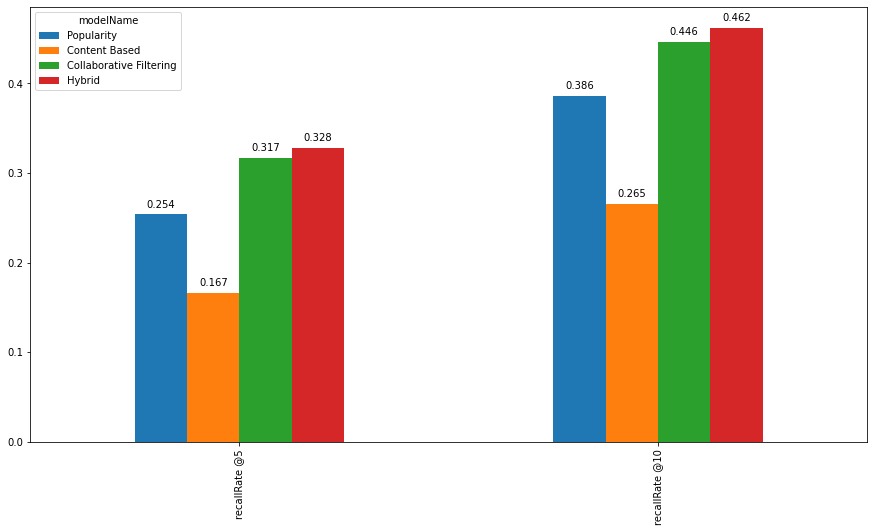

In [48]:
%matplotlib inline
ax = allResultMetrics.transpose().plot(kind='bar', figsize=(15,8))
for p in ax.patches:
    ax.annotate("%.3f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')

# Testing

Let's test the best model (Hybrid) for a user.

In [84]:
def inspectInteractions(userId, test_set=True):
    if test_set:
        interactions = indexedTestInteractions
    else:
        interactions = indexedTrainInteractions
    return interactions.loc[userId].merge(articles, how = 'left', 
                                                       left_on = 'contentId', 
                                                       right_on = 'contentId').sort_values('eventStrength', ascending = False)[['eventStrength', 
                                                                                                                                'contentId',
                                                                                                                                'title', 'url', 'lang']]

Here we see some articles I interacted in Deskdrop from train set. It can be easily observed that among my main interests are **machine learning**, **deep learning**, **artificial intelligence**, and **google cloud platform**.

In [85]:
inspectInteractions(-1479311724257856983, test_set=False).head(20)

,eventStrength,contentId,title,url,lang
19,4.129283,621816023396605502,AI Is Here to Help You Write Emails People Wil...,http://www.wired.com/2016/08/boomerang-using-a...,en
83,3.906891,2589533162305407436,6 reasons why I like KeystoneML,http://radar.oreilly.com/2015/07/6-reasons-why...,en
97,3.700440,5258604889412591249,Machine Learning Is No Longer Just for Experts,https://hbr.org/2016/10/machine-learning-is-no...,en
25,3.643856,-6467708104873171151,5 reasons your employees aren't sharing their ...,http://justcuriousblog.com/2016/04/5-reasons-y...,en
1,3.523562,-4944551138301474550,Algorithms and architecture for job recommenda...,https://www.oreilly.com/ideas/algorithms-and-a...,en
59,3.459432,-532999578436827210,IBM Seeks to Simplify Graph with New Titan Ser...,https://www.datanami.com/2016/07/27/ibm-seeks-...,en
62,3.459432,-8377626164558006982,Bad Writing Is Destroying Your Company's Produ...,https://hbr.org/2016/09/bad-writing-is-destroy...,en
12,3.459432,-5658245291907121574,Machine Learning and the VP Debate,https://medium.com/@srobtweets/machine-learnin...,en
76,3.321928,-8085935119790093311,Graph Capabilities with the Elastic Stack,https://www.elastic.co/webinars/sneak-peek-of-...,en
26,3.169925,6340108943344143104,Text summarization with TensorFlow,https://research.googleblog.com/2016/08/text-s...,en


**The recommendations really matches the user interests**

In [86]:
hybridModel.recommendItems(-1479311724257856983, topN=20)

                contentId  recStrength
0    -8085935119790093311     0.300061
1    -1901742495252324928     0.290575
2    -6467708104873171151     0.289739
3     1005751836898964351     0.289370
4    -8190931845319543363     0.288608
...                   ...          ...
2860 -3739000323288188282     0.174992
2861 -2720012228333470715     0.172850
2862  7818691400791322406     0.172522
2863  7255021292858609470     0.170994
2864 -7463305179076477879     0.169683

[2865 rows x 2 columns]


,recStrengthCB,contentId,title_x,url_x,lang_x,recStrengthCF,title_y,url_y,lang_y,recStrengthHybrid
696,0.206931,-8085935119790093311,Graph Capabilities with the Elastic Stack,https://www.elastic.co/webinars/sneak-peek-of-...,en,0.300061,Graph Capabilities with the Elastic Stack,https://www.elastic.co/webinars/sneak-peek-of-...,en,30.213057
190,0.305148,-1901742495252324928,Designing smart notifications,https://medium.com/@intercom/designing-smart-n...,en,0.290575,Designing smart notifications,https://medium.com/@intercom/designing-smart-n...,en,29.362619
365,0.256083,-6467708104873171151,5 reasons your employees aren't sharing their ...,http://justcuriousblog.com/2016/04/5-reasons-y...,en,0.289739,5 reasons your employees aren't sharing their ...,http://justcuriousblog.com/2016/04/5-reasons-y...,en,29.230024
219,0.295269,-8190931845319543363,Machine Learning Is At The Very Peak Of Its Hy...,https://arc.applause.com/2016/08/17/gartner-hy...,en,0.288608,Machine Learning Is At The Very Peak Of Its Hy...,https://arc.applause.com/2016/08/17/gartner-hy...,en,29.156064
183,0.306695,4118743389464105405,Why Google App Engine rocks: A Google engineer...,https://cloudplatform.googleblog.com/2016/04/w...,en,0.286364,Why Google App Engine rocks: A Google engineer...,https://cloudplatform.googleblog.com/2016/04/w...,en,28.943137
1000,0.000000,1005751836898964351,0.0,0.0,0.0,0.289370,Seria Stranger Things uma obra de arte do algo...,https://www.linkedin.com/pulse/seria-stranger-...,pt,28.937041
9,0.484134,-9033211547111606164,Google's Cloud Machine Learning service is now...,https://techcrunch.com/2016/09/29/googles-clou...,en,0.278756,Google's Cloud Machine Learning service is now...,https://techcrunch.com/2016/09/29/googles-clou...,en,28.359686
17,0.458899,-5756697018315640725,Being A Developer After 40 - Free Code Camp,https://medium.freecodecamp.com/being-a-develo...,en,0.278992,Being A Developer After 40 - Free Code Camp,https://medium.freecodecamp.com/being-a-develo...,en,28.358117
1001,0.000000,-1556169727291354289,0.0,0.0,0.0,0.282191,Why Netflix thinks its personalized recommenda...,http://www.businessinsider.com/netflix-recomme...,en,28.219149
13,0.468573,2589533162305407436,6 reasons why I like KeystoneML,http://radar.oreilly.com/2015/07/6-reasons-why...,en,0.276123,6 reasons why I like KeystoneML,http://radar.oreilly.com/2015/07/6-reasons-why...,en,28.080847


# References

1. [https://www.kaggle.com/kanncaa1/recommendation-systems-tutorial](https://www.kaggle.com/kanncaa1/recommendation-systems-tutorial)
2. [https://www.kaggle.com/gspmoreira/recommender-systems-in-python-101/notebook](https://www.kaggle.com/gspmoreira/recommender-systems-in-python-101/notebook)